In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999999;

<IPython.core.display.Javascript object>

In [2]:
# get rid of GPU logging messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"]='2,3'

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

import tensorflow_addons as tfa

import numpy as np
import random

/scratch/student/cb2078/env/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# if using a gpu limit its memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print('e',e)

2 Physical GPUs, 2 Logical GPUs


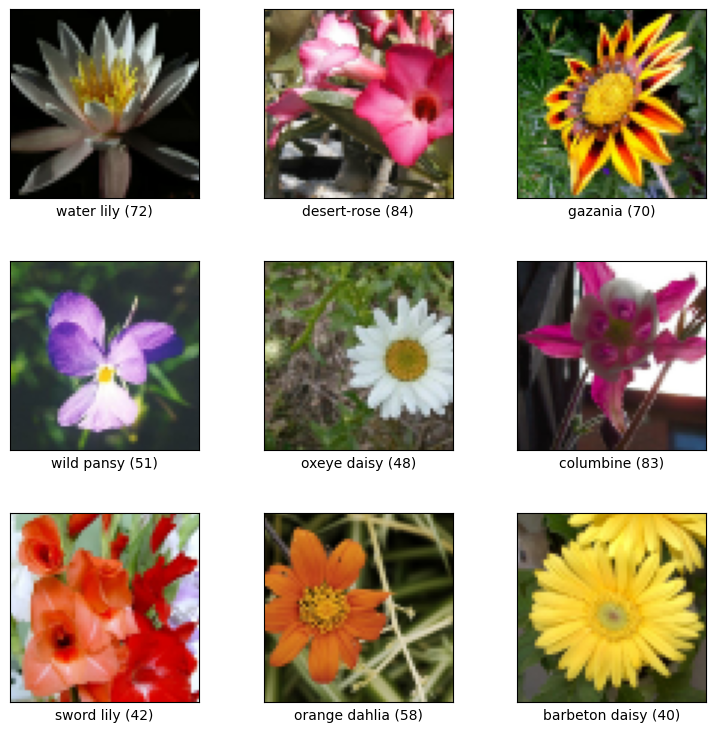

In [4]:


#Load the training and testing dataset
#TODO Validation dataset
(ds_train, ds_test, ds_val), ds_info = tfds.load('oxford_flowers102',
                                            split=['train', 'test', 'validation'],
                                            with_info=True,
                                            shuffle_files=True,
                                            as_supervised=True)




#This gets the images ready
shape = (128, 128, 3)
big_shape = (200,200,3)
small_shape = (64, 64, 3)
n_labels = 102
def normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255
    img = tf.keras.preprocessing.image.smart_resize(img,shape[:2])
    return (img, label)


def resize_img(img, label):
    img = tf.image.resize(img,small_shape[:2])
    return (img, label)


def randomize_img1(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img,0.15)
    img = tf.image.random_contrast(img,0.5,0.9)
    img = tf.image.random_saturation(img, 0.5,0.9)
    img = tf.image.random_hue(img, 0.2)
    return (img, label)


def randomize_img2(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_saturation(img, 0.4,0.9)
    return (img, label)


def randomize_img3(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img,0.15)
    img = tf.image.random_contrast(img,0.3,0.9)
    return (img, label)


def randomize_saturation(img, label):
    img = tf.image.random_saturation(img, 0.5,0.9)
    img = tf.image.random_hue(img, 0.025)
    return (img, label)




def randomize_brightness(img, label):
    img = tf.image.random_brightness(img,0.05)
    img = tf.image.random_contrast(img,0.5,0.9)
    return (img, label)


def random_flip_img(img, label):
    img = tf.image.random_flip_left_right(img)
    return (img, label)


def rotate_img(img, label):
    img = tfa.image.rotate(img, angles=0.5)
    return (img, label)


def random_crop(img, label):
    img = tf.image.resize(img,big_shape[:2])
    img = tf.image.random_crop(img, (128,128,3))
    return (img, label)


def random_move_img(img, label):
    img = tfa.image.rotate(img, angles=random.uniform(-0.5, 0.5))
    img = tfa.image.translate(img, [np.random.random()*30-15,np.random.random()*30-15])
    return (img, label)


def random_test(img, label):
   
    return (img, label)


def random_cutout(img, label):
    cutout_size = random.randint(16,48)
    n_cutouts = random.randint(2,5)
    for _ in range(n_cutouts):
        # image.cutout needs a 4d tensor but img is a 3d tensor
        img = tf.expand_dims(img, 0)
        img = tfa.image.cutout(img, 32,
                               [random.randint(0, shape[0]), random.randint(0, shape[1])])
        img = img[0,]
    return img, label


def random_image_warp(img, label):
    n_warp_points = 25
    offset = 5
   
    offsets = tf.random.uniform(shape = [n_warp_points, 2], minval = -offset, maxval = offset)
    src_points = tf.random.uniform(shape = [n_warp_points, 2], maxval = shape[0])
    dest_points = src_points + offsets
    img, flow = tfa.image.sparse_image_warp([img], [src_points], [dest_points])
    img = img[0,]
    return img, label






def random_randomthings(img, label):
    for i in range (0,random.randint(1,4)):
        random_value = random.randint(0,6)
        if random_value == 0:
            img, label = random_flip_img(img, label)
        elif random_value == 1:
            img, label = random_move_img(img, label)
        elif random_value == 2:
            img, label = randomize_brightness(img, label)
        elif random_value == 3:
            img, label = randomize_brightness(img, label)
        elif random_value == 4:
            img, label = randomize_saturation(img, label)
        elif random_value == 5:
            img =  tf.image.random_contrast(img,0.3,0.9)
        # elif random_value == 6:
        #     img, label = random_crop(img, label)


    return (img, label)




AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
#ds_train = ds_train.map(randomize_saturation, num_parallel_calls=AUTOTUNE)





#Random Brightness
ds_brightness_train = ds_train.map(randomize_brightness)
ds_brightness2_train = ds_train.map(randomize_brightness)
ds_brightness3_train = ds_train.map(randomize_brightness)

#Random Brightness and crop
ds_brightness_crop_train = ds_train.map(randomize_brightness)
ds_brightness_crop_train = ds_brightness_crop_train.map(random_crop)

ds_brightness_crop2_train = ds_train.map(randomize_brightness)
ds_brightness_crop2_train = ds_brightness_crop2_train.map(random_crop)

#Random Saturation
ds_saturation_train = ds_train.map(randomize_saturation)
ds_saturation2_train = ds_train.map(randomize_saturation)
ds_saturation3_train = ds_train.map(randomize_saturation)

#Random Saturation and crop
ds_saturation_crop_train = ds_train.map(randomize_saturation)
ds_saturation_crop_train = ds_saturation_crop_train.map(random_crop)

ds_saturation_crop2_train = ds_train.map(randomize_saturation)
ds_saturation_crop2_train = ds_saturation_crop2_train.map(random_crop)


#Random Crop
ds_crop_train = ds_train.map(random_crop)
ds_crop2_train = ds_train.map(random_crop)
ds_crop3_train = ds_train.map(random_crop)


#Random Move
ds_move_train = ds_train.map(random_move_img)
ds_move2_train = ds_train.map(random_move_img)
ds_move3_train = ds_train.map(random_move_img)
ds_move4_train = ds_train.map(random_move_img)

#Random cutout
ds_cutout_train = ds_train.map(random_cutout)
ds_cutout2_train = ds_train.map(random_cutout)
ds_cutout3_train = ds_train.map(random_cutout)

#Random Warp
ds_warp_train = ds_train.map(random_image_warp)
ds_warp2_train = ds_train.map(random_image_warp)
ds_warp3_train = ds_train.map(random_image_warp)

#Random lots
ds_random_train = ds_train.map(randomize_brightness)
ds_random_train = ds_random_train.map(random_image_warp)
ds_random_train = ds_random_train.map(random_move_img)

ds_randomv2_train = ds_train.map(randomize_brightness)
ds_randomv2_train = ds_randomv2_train.map(random_image_warp)
ds_randomv2_train = ds_randomv2_train.map(random_move_img)


#Random lotsV2
ds_random2v2_train = ds_train.map(randomize_saturation)
ds_random2v2_train = ds_random2v2_train.map(random_image_warp)
ds_random2v2_train = ds_random2v2_train.map(random_cutout)
ds_random2v2_train = ds_random2v2_train.map(random_move_img)

ds_random2_train = ds_train.map(randomize_saturation)
ds_random2_train = ds_random2_train.map(random_image_warp)
ds_random2_train = ds_random2_train.map(random_cutout)
ds_random2_train = ds_random2_train.map(random_move_img)


#Random lots v3
ds_random3_train = ds_train.map(randomize_saturation)
ds_random3_train = ds_random3_train.map(random_image_warp)
ds_random3_train = ds_random3_train.map(random_cutout)
ds_random3_train = ds_random3_train.map(random_move_img)
ds_random3_train = ds_random3_train.map(randomize_saturation)

ds_random3v2_train = ds_train.map(randomize_saturation)
ds_random3v2_train = ds_random3v2_train.map(random_image_warp)
ds_random3v2_train = ds_random3v2_train.map(random_cutout)
ds_random3v2_train = ds_random3v2_train.map(random_move_img)
ds_random3v2_train = ds_random3v2_train.map(randomize_saturation)


#Random Lots v4
ds_random4_train = ds_train.map(randomize_brightness)
ds_random4_train = ds_random4_train.map(random_crop)
ds_random4_train = ds_random4_train.map(random_move_img)

ds_random4v2_train = ds_train.map(randomize_brightness)
ds_random4v2_train = ds_random4v2_train.map(random_crop)
ds_random4v2_train = ds_random4v2_train.map(random_move_img)


#Random Lots v5
ds_random5_train = ds_train.map(randomize_brightness)
ds_random5_train = ds_random5_train.map(random_crop)
ds_random5_train = ds_random5_train.map(random_move_img)
ds_random5_train = ds_random5_train.map(random_cutout)

ds_random5v2_train = ds_train.map(randomize_brightness)
ds_random5v2_train = ds_random5v2_train.map(random_crop)
ds_random5v2_train = ds_random5v2_train.map(random_move_img)
ds_random5v2_train = ds_random5v2_train.map(random_cutout)


#Random lots v6
ds_random6_train = ds_train.map(randomize_saturation)
ds_random6_train = ds_random6_train.map(random_move_img)
ds_random6_train = ds_random6_train.map(randomize_saturation)
ds_random6_train = ds_random6_train.map(random_image_warp)
ds_random6_train = ds_random6_train.map(random_crop)

ds_random6v2_train = ds_train.map(randomize_saturation)
ds_random6v2_train = ds_random6v2_train.map(random_move_img)
ds_random6v2_train = ds_random6v2_train.map(randomize_saturation)
ds_random6v2_train = ds_random6v2_train.map(random_image_warp)
ds_random6v2_train = ds_random6v2_train.map(random_crop)


ds_train = ds_train.concatenate(ds_brightness_train)
ds_train = ds_train.concatenate(ds_brightness2_train)
ds_train = ds_train.concatenate(ds_brightness3_train)
ds_train = ds_train.concatenate(ds_brightness_crop_train)
ds_train = ds_train.concatenate(ds_brightness_crop2_train)
ds_train = ds_train.concatenate(ds_saturation_train)
ds_train = ds_train.concatenate(ds_saturation2_train)
ds_train = ds_train.concatenate(ds_saturation3_train)
ds_train = ds_train.concatenate(ds_saturation_crop_train)
ds_train = ds_train.concatenate(ds_saturation_crop2_train)
ds_train = ds_train.concatenate(ds_crop_train)
ds_train = ds_train.concatenate(ds_crop2_train)
ds_train = ds_train.concatenate(ds_crop3_train)
ds_train = ds_train.concatenate(ds_move_train)
ds_train = ds_train.concatenate(ds_move2_train)
ds_train = ds_train.concatenate(ds_move3_train)
ds_train = ds_train.concatenate(ds_move4_train)
ds_train = ds_train.concatenate(ds_cutout_train)
ds_train = ds_train.concatenate(ds_cutout2_train)
ds_train = ds_train.concatenate(ds_cutout3_train)
ds_train = ds_train.concatenate(ds_random_train)
ds_train = ds_train.concatenate(ds_random2_train)
#ds_train = ds_train.concatenate(ds_randomv2_train)
#ds_train = ds_train.concatenate(ds_random2v2_train)
ds_train = ds_train.concatenate(ds_random3_train)
#ds_train = ds_train.concatenate(ds_random3v2_train)
ds_train = ds_train.concatenate(ds_random4_train)
#ds_train = ds_train.concatenate(ds_random4v2_train)
ds_train = ds_train.concatenate(ds_random5_train)
#ds_train = ds_train.concatenate(ds_random5v2_train)
ds_train = ds_train.concatenate(ds_random6_train)
#ds_train = ds_train.concatenate(ds_random6v2_train)
ds_train = ds_train.concatenate(ds_warp_train)
ds_train = ds_train.concatenate(ds_warp2_train)
ds_train = ds_train.concatenate(ds_warp3_train)


ds_flip_train = ds_train.map(random_flip_img)
ds_train = ds_train.concatenate(ds_flip_train)
#ds_train = ds_train.concatenate(ds_train)
ds_train = ds_train.map(resize_img)


tfds.visualization.show_examples(ds_train, ds_info)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(1000)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)


ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test =ds_test.map(resize_img)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(AUTOTUNE)


ds_val = ds_val.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_val =ds_val.map(resize_img)
ds_val = ds_val.cache()
ds_val = ds_val.shuffle(1000)
ds_val = ds_val.batch(BATCH_SIZE)
ds_val = ds_val.prefetch(AUTOTUNE)



In [5]:
print(ds_train.cardinality().numpy() * BATCH_SIZE)

61216


In [6]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    input = tf.keras.layers.Input(small_shape)
    
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=2)(x)
    
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=2)(x)
    
    x = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=2)(x)
    
    x = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation="relu")(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
        
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(2048, activation="relu", kernel_regularizer=regularizers.l2(l=0.001))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
  
    output = tf.keras.layers.Dense(n_labels, activation="softmax")(x)

    model = tf.keras.Model(input, output)

    #Learning rate scheduler (EXPLAIN THIS)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=10000,
        decay_rate=0.9
    )

    model.compile(
        optimizer=keras.optimizers.Adam(lr_schedule),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0     

In [7]:
#Train the model 
history = model.fit(
    ds_train,
    epochs=130,
    validation_data=ds_val)

Epoch 1/130
INFO:tensorflow:batch_all_reduce: 34 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 34 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 34 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 34 all-reduces with algorithm = nccl, num_packs = 1


1913/1913 [==============================] - 229s 111ms/step - loss: 3.2235 - accuracy: 0.3036 - val_loss: 3.1299 - val_accuracy: 0.4255
Epoch 2/130
1913/1913 [==============================] - 51s 26ms/step - loss: 1.4961 - accuracy: 0.7131 - val_loss: 2.8408 - val_accuracy: 0.6098
Epoch 3/130
1913/1913 [==============================] - 53s 27ms/step - loss: 0.9650 - accuracy: 0.8483 - val_loss: 2.4093 - val_accuracy: 0.6343
Epoch 4/130
1913/1913 [==============================] - 52s 27ms/step - loss: 0.7609 - accuracy: 0.8955 - val_loss: 2.7705 - val_accuracy: 0.6461
Epoch 5/130
1913/1913 [==============================] - 53s 28ms/step - loss: 0.6461 - accuracy: 0.9189 - val_loss: 2.3497 - val_accuracy: 0.6657
Epoch 6/130
1913/1913 [==============================] - 52s 27ms/step - loss: 0.5678 - accuracy: 0.9336 - val_loss: 2.2234 - val_accuracy: 0.6804
Epoch 7/130
1913/1913 [==============================] - 51s 27ms/step - loss: 0.5047 - accuracy: 0.9449 - val_loss: 2.2974 - va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1913/1913 [==============================] - 50s 26ms/step - loss: 0.1379 - accuracy: 0.9921 - val_loss: 2.2130 - val_accuracy: 0.7441
Epoch 37/130
1913/1913 [==============================] - 52s 27ms/step - loss: 0.1268 - accuracy: 0.9933 - val_loss: 2.5708 - val_accuracy: 0.7235
Epoch 38/130
1913/1913 [==============================] - 52s 27ms/step - loss: 0.1220 - accuracy: 0.9934 - val_loss: 2.3407 - val_accuracy: 0.7461
Epoch 39/130
1693/1913 [=========================>....] - ETA: 5s - loss: 0.1173 - accuracy: 0.9937

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



193/193 - 4s - loss: 2.0672 - accuracy: 0.7494 - 4s/epoch - 21ms/step


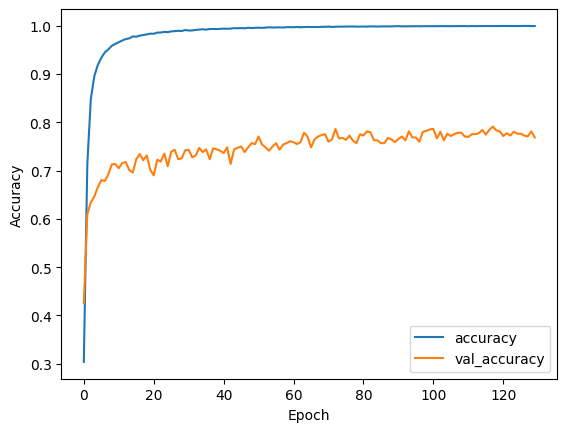

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_test, verbose=2)